# <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Predição de Risco de Inundação (pt-BR)</div>

<img src="./images/header.png" style="width:100%;height:400px;object-fit:cover;border-radius:10px;filter:grayscale(50%)" alt="Rio Grande do Sul"/>

## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#CD3E38;color:white;overflow:hidden;margin:0;">Nota do Autor</div>

<div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#CD3E38;color:white;overflow:hidden;margin:0;">
As recentes inundações no Rio Grande do Sul, causadas por chuvas torrenciais, geraram um cenário de devastação e sofrimento para milhares de pessoas. Casas foram destruídas, negócios interrompidos e vidas perdidas. Diante dessa tragédia, torna-se crucial desenvolver ferramentas que auxiliem na mitigação de futuros desastres.<br>Por essa infeliz coincidência o <a href="https://www.kaggle.com/competitions/playground-series-s4e5" style="color:white;font-weight:bold;text-decoration: underline;">Kaggle</a> está promovendo uma competição para prever a probabilidade de uma região ser inundada com base em vários fatores. Os dados utilizados na competição são sintéticos, mas podemos avançar para quem sabe no futuro, ter modelos efetivos que possam ajudar em outros casos.<br>Este notebook apresenta um estudo de <b>Predição de Risco de Inundação</b>. Através de técnicas de Machine Learning, o objetivo é construir um modelo capaz de identificar áreas com maior probabilidade de sofrer inundações, permitindo que medidas preventivas sejam tomadas com antecedência.<br>Minhas sinceras condolências ao povo do Rio Grande do Sul. Que tenham força e que Deus possa confortar o coração dos familiares que perderam seus entes queridos.
</div>

<img src="./images/flag.png" style="width:100%;border-radius:10px;filter:grayscale(100%)"/>

## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Tabela de Conteúdo</div>

- [Importação das bibliotecas](#1)
- [Funções Customizadas](#2)
- [Constantes](#3)
- [Informações sobre a base de dados](#4)
- [Importação das bases de dados](#5)
- [Mostrar as primeiras linhas dos dados de treinamento](#6)
- [Comparação dos dados originais com os dados de treino](#7)
- [Salvar os ids para submissão e eliminação dos ids nos dados](#8)
- [Concatenar os dados de treinamento original com o da competição](#9)
- [Verificar quantos duplicados existem nos dados](#10)
- [Formatos dos dados de treinamento e teste](#11)
- [Separar as variáveis numéricas e categóricas](#12)
- [Exibir estatísticas descritivas dos dados de treinamento](#13)
- [Verifique o número de valores nulos para cada característica](#14)
- [Tipos das variáveis nos dados treinamento](#15)
- [Histogramas da distribuição](#16)
- [Matriz de correlação](#17)
- [Visualização das características numéricas](#18)
- [Distribuição da variável alvo (target)](#19)
- [Preparação dos dados](#20)
- [Otimização de hiperparâmetros](#21)
- [Definição de Hiperparâmetros do Modelo LGBM](#22)
- [Validação cruzada e predição](#23)
- [Arquivo de submissão do Kaggle](#24)
- [Próximos passos](#25)
- [Considerações finais](#26)
- [Contato](#27)
- [Referênicas](#28)

<a id='1'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Importação das bibliotecas</div>

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

from lightgbm import LGBMRegressor

sns.set_style("whitegrid")

<a id='2'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Funções Customizadas</div>

In [2]:
def plot_correlation(df, type = 'pearson'):
    correlation_matrix = df.corr(method=type)

    plt.figure(figsize=(18, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".4f", cbar=False)
    plt.show()

def plot_numerical(numeric_cols):
    df = pd.concat([train[numeric_cols].assign(Source = 'Train'), 
                    test[numeric_cols].assign(Source = 'Test')], ignore_index = True)

    _, axes = plt.subplots(len(numeric_cols), 3 ,figsize = (16, len(numeric_cols) * 4), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 
                                            'width_ratios': [0.80, 0.20, 0.20]})

    for i,col in enumerate(numeric_cols):
        ax = axes[i,0]
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#0066B3', '#983E51'], linewidth = 2.1, warn_singular=False, ax = ax)
        ax.set_title(f"\n{col}",fontsize = 9)
        ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
        ax.set(xlabel = '', ylabel = '')

        ax = axes[i,1]
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#0066B3', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title("Train", fontsize = 9)

        ax = axes[i,2]
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#983E51', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title("Test", fontsize = 9)

    plt.show()

<a id='3'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Constantes</div>

In [3]:
np.random.seed(27)
random.seed(27)

STATE = 27
TARGET = 'FloodProbability'
SUB_PATH = './submissions/'

<a id='4'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Informações sobre a base de dados</div>

- **MonsoonIntensity** (Intensidade das chuvas durante monções)
- **TopographyDrainage** (Qualidade do sistema de drenagem em relação à topografia)
- **RiverManagement** (Gestão dos rios)
- **Deforestation** (Extensão da desflorestação)
- **Urbanization** (Nível de urbanização)
- **ClimateChange** (Impacto das mudanças climáticas)
- **DamsQuality** (Qualidade das barragens)
- **Siltation** (Acúmulo de sedimentos)
- **AgriculturalPractices** (Práticas agrícolas)
- **Encroachments** (Ocupações ilegais)
- **IneffectiveDisasterPreparedness** (Preparação inadequada para desastres)
- **DrainageSystems** (Estado dos sistemas de drenagem)
- **CoastalVulnerability** (Vulnerabilidade costeira)
- **Landslides** (Risco de deslizamentos de terra)
- **Watersheds** (Bacias hidrográficas)
- **DeterioratingInfrastructure** (Infraestrutura deteriorada)
- **PopulationScore** (Densidade populacional)
- **WetlandLoss** (Perda de áreas úmidas)
- **InadequatePlanning** (Planejamento inadequado)
- **PoliticalFactors** (Fatores políticos)
- **FloodProbability** (Probabilidade de inundação)

<a id='5'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Importação das bases de dados</div>

In [4]:
sample_submission = pd.read_csv('./data/sample_submission.csv')

original_train = pd.read_csv('./data/flood.csv')

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

<a id='6'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Mostrar as primeiras linhas dos dados de treinamento</div>

In [5]:
pd.set_option('display.max_columns', None)
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


<a id='7'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Comparação dos dados originais com os dados de treino</div>

In [6]:
print(original_train.shape)
original_train.columns.tolist()

(50000, 21)


['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

In [7]:
print(train.shape)
train.columns.tolist()

(1117957, 22)


['id',
 'MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

### <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;background-color:#0066B3;color:white;overflow:hidden;margin:0;font-style:italic;padding: 4px 0;"><div style="border-bottom: 1px solid #ccc;font-weight: bold">Comentário:</div>Nos dados originais não existe a coluna **id**</div>


<a id='8'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Salvar os ids para submissão e eliminação dos ids nos dados</div>

In [8]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

<a id='9'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Concatenar os dados de treinamento original com o da competição</div>

In [9]:
train.reset_index(drop=True, inplace=True)
original_train.reset_index(drop=True, inplace=True)

train = pd.concat([train, original_train], ignore_index=True)

<a id='10'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Verificar quantos duplicados existem nos dados</div>

In [10]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

0
0


<a id='11'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Formatos dos dados de treinamento e teste</div>

In [11]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Os dados de treinamento consistem em {round(train_data_percentage * 100, 2)}% do total de observações')
print(f'Os dados de teste consistem em {round((1 - train_data_percentage) * 100, 2)}% do total de observações')

Train data: (1167957, 21)
Test data: (745305, 20)

Os dados de treinamento consistem em 61.05% do total de observações
Os dados de teste consistem em 38.95% do total de observações


<a id='12'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Separar as variáveis numéricas e categóricas</div>

In [12]:
NUMERIC_COLS = [f for f in train._get_numeric_data() if f not in TARGET]
CAT_COLS = list(test.drop(NUMERIC_COLS,axis=1))

print(f'Variáveis numéricas: {len(NUMERIC_COLS)}')
print(f'Variáveis categóricas: {len(CAT_COLS)}')

Variáveis numéricas: 20
Variáveis categóricas: 0


<a id='13'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Exibir estatísticas descritivas dos dados de treinamento</div>

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1167957.0,4.924448,2.064482,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1167957.0,4.929129,2.100671,0.000,3.00,5.000,6.00,18.000
RiverManagement,1167957.0,4.957917,2.079283,0.000,4.00,5.000,6.00,16.000
Deforestation,1167957.0,4.945076,2.059346,0.000,4.00,5.000,6.00,17.000
Urbanization,1167957.0,4.944509,2.090501,0.000,3.00,5.000,6.00,17.000
ClimateChange,1167957.0,4.936415,2.065289,0.000,3.00,5.000,6.00,17.000
DamsQuality,1167957.0,4.958424,2.090286,0.000,4.00,5.000,6.00,16.000
Siltation,1167957.0,4.930394,2.073436,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1167957.0,4.945338,2.075964,0.000,3.00,5.000,6.00,16.000
Encroachments,1167957.0,4.951676,2.090378,0.000,4.00,5.000,6.00,18.000


<a id='14'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Verifique o número de valores nulos para cada característica</div>

In [14]:
print('Dados de treinamento\n')
print(f'{train.isna().sum()}\n\n\n')

print('Dados de teste\n')
print(test.isna().sum())

Dados de treinamento

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64



Dados de teste

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization         

### <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;background-color:#0066B3;color:white;overflow:hidden;margin:0;font-style:italic;padding: 4px 0;"><div style="border-bottom: 1px solid #ccc;font-weight: bold">Comentário:</div>Não há valores nulos nos dados de treinamento e teste.</div>


<a id='15'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Tipos das variáveis nos dados treinamento</div>

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167957 entries, 0 to 1167956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null 

<a id='16'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Histogramas da distribuição</div>

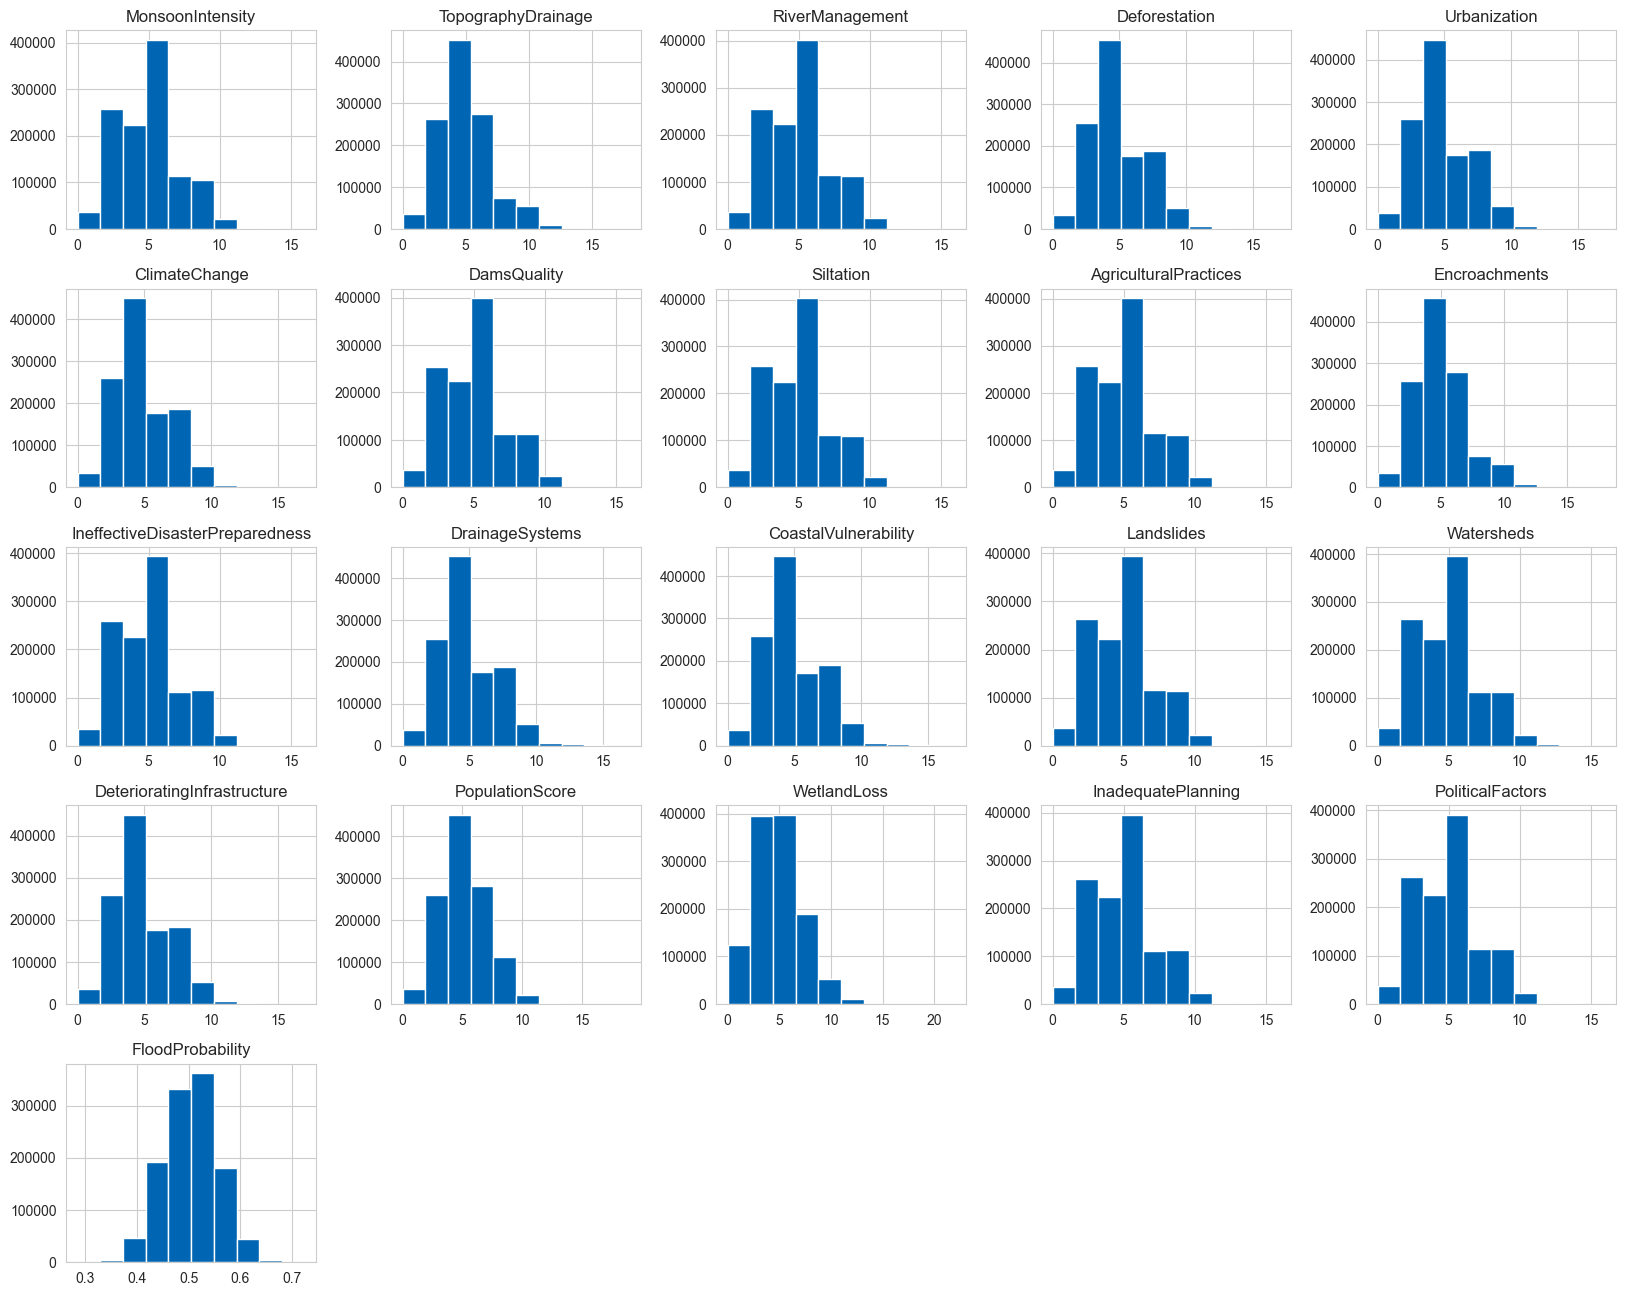

In [16]:
train.hist(color='#0066B3', figsize=(20, 16))
plt.show()

<a id='17'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Matriz de correlação</div>

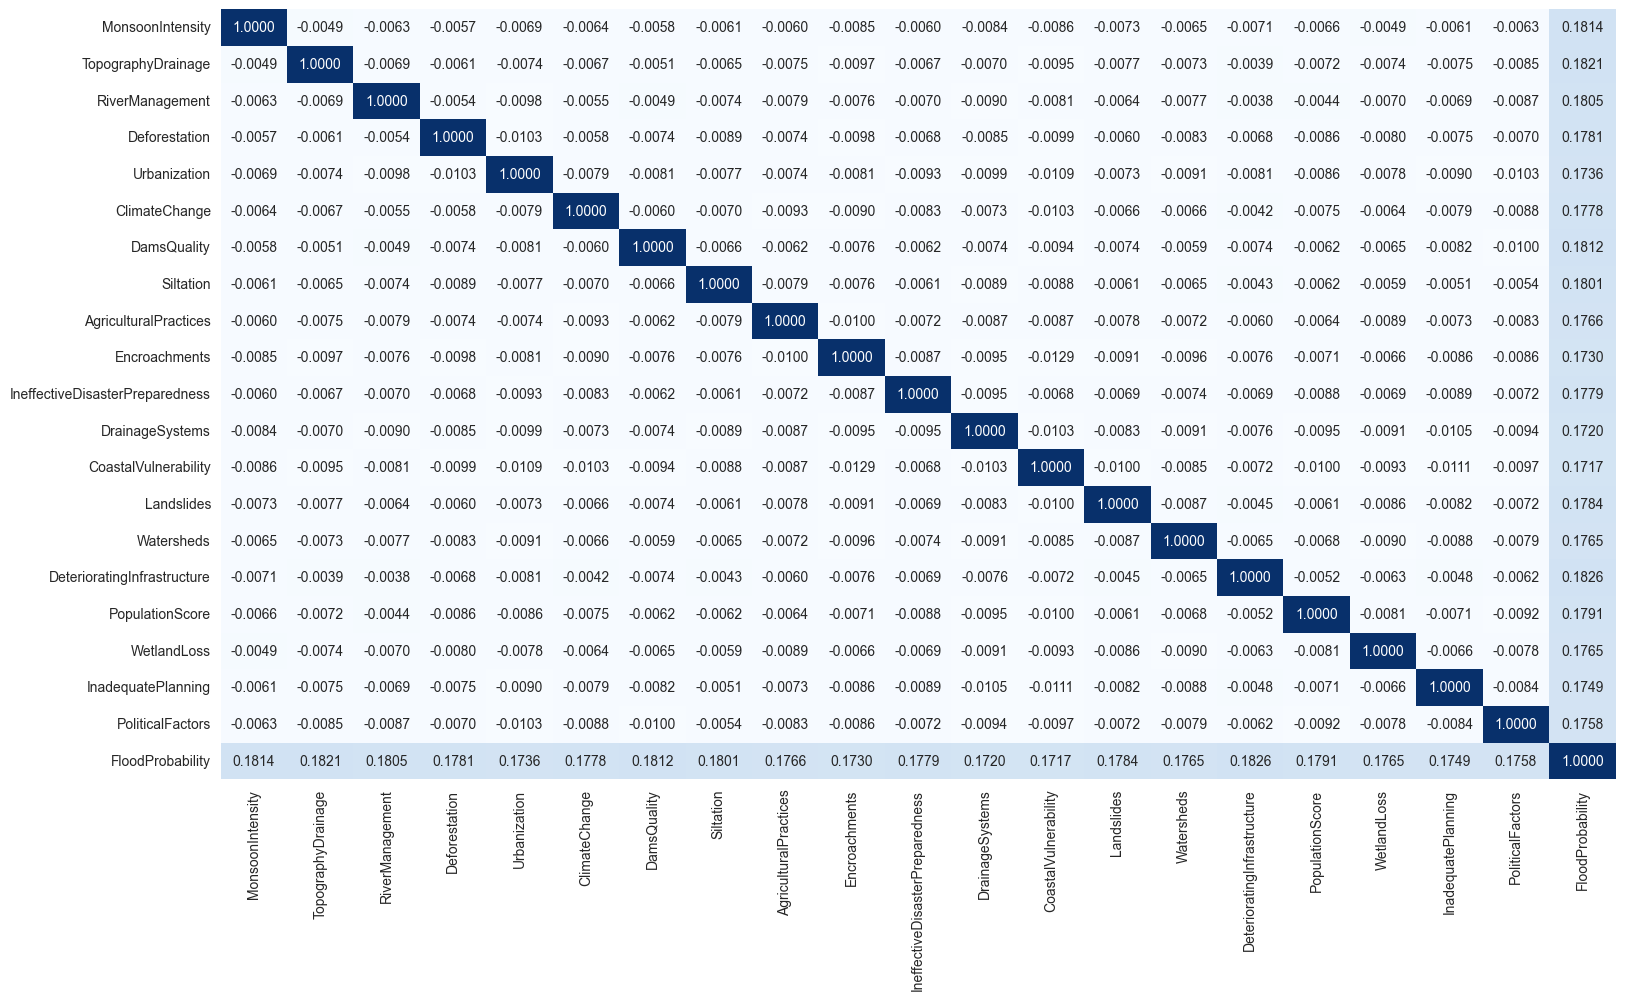

In [17]:
plot_correlation(train, 'spearman')

<a id='18'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Visualização das características numéricas</div>

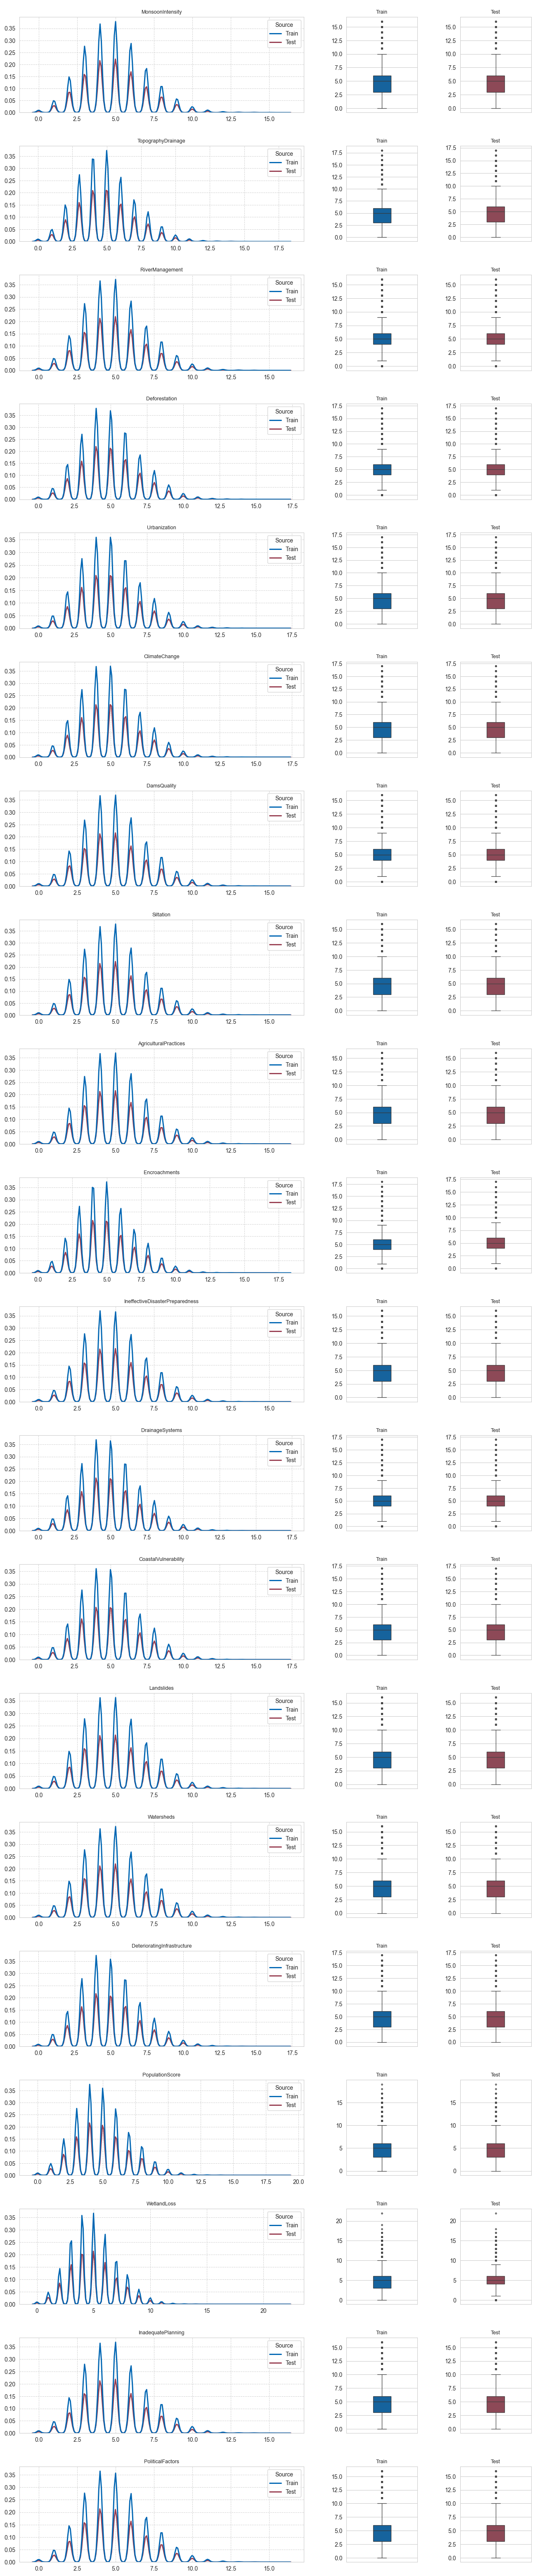

In [18]:
plot_numerical(NUMERIC_COLS)

### <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;background-color:#0066B3;color:white;overflow:hidden;margin:0;font-style:italic;padding: 4px 0;"><div style="border-bottom: 1px solid #ccc;font-weight: bold">Comentário:</div>Os dados de treino e de teste possuem distribuição similar</div>

<a id='19'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Distribuição da variável alvo (target)</div>

0.04956565042772249


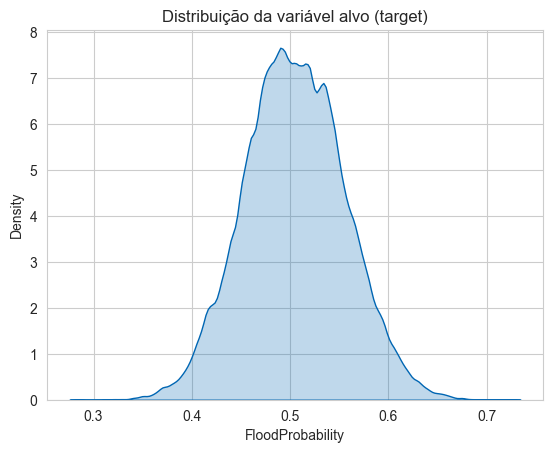

In [19]:
sns.kdeplot(train[TARGET], fill=True, color='#0066B3')
plt.title('Distribuição da variável alvo (target)')

print(train[TARGET].skew())

### <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;background-color:#0066B3;color:white;overflow:hidden;margin:0;font-style:italic;padding: 4px 0;"><div style="border-bottom: 1px solid #ccc;font-weight: bold">Comentário:</div>A distribuição da nossa variável alvo se aproxima de uma distribuição normal.</div>

<a id='20'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Preparação dos dados</div>

In [20]:
X = train.copy().drop([TARGET], axis=1)
y = train[TARGET]

print(f'Tamanho X: {X.shape}')
print(f'Tamanho y: {y.shape}')
print(f'Tamanho test: {test.shape}')

Tamanho X: (1167957, 20)
Tamanho y: (1167957,)
Tamanho test: (745305, 20)


<a id='21'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Otimização de hiperparâmetros</div>

In [21]:
# %%time
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 400, 800),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 0.01),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 0.01),
#         'max_depth': trial.suggest_int('max_depth', 10, 20),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 40),
#         'num_leaves': trial.suggest_int('num_leaves', 50, 70),
#     }

#     model = LGBMRegressor(
#         **params,
#         random_state=STATE,
#         verbose= -1,
#         n_jobs= -1
#     )

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return r2_score(y_test, y_pred)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=STATE)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# best_trial = study.best_trial
# print(f"Best Trial - Hyperparameters: {best_trial.params}")
# print(f"Best Trial - R2 SCORE: {best_trial.value}")

# # Best Trial - Hyperparameters: {'n_estimators': 793, 'learning_rate': 0.03865484739534257, 'lambda_l1': 0.0034508594796758196, 'lambda_l2': 0.0011116199701953623, 'max_depth': 19, 'colsample_bytree': 0.6258162925982894, 'subsample': 0.9991743037147245, 'min_child_samples': 26, 'num_leaves': 55}
# # Best Trial - R2 SCORE: 0.8454351685259036
# # CPU times: total: 8h 16min 59s
# # Wall time: 51min 45s

<a id='22'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Definição de Hiperparâmetros do Modelo LGBM</div>

In [22]:
lgbm_params = {
  "n_estimators": 793,
  "learning_rate": 0.03865484739534257,
  "lambda_l1": 0.0034508594796758196,
  "lambda_l2": 0.0011116199701953623,
  "max_depth": 19,
  "colsample_bytree": 0.6258162925982894,
  "subsample": 0.9991743037147245,
  "min_child_samples": 26,
  "num_leaves": 55
}

model_lgbm = LGBMRegressor(
                  **lgbm_params,
                  random_state=STATE,
                  verbose= -1,
                  n_jobs= -1
              )

<a id='23'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Validação cruzada e predição</div>

In [23]:
%%time

scores = []
y_pred_test = []

y_pred_valid = []
index_pred_valid = []

cv = KFold(n_splits=5, shuffle=True, random_state=STATE)

for fold_i, (train_index, valid_index) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    model_lgbm.fit(X_train, y_train)
    
    y_pred = model_lgbm.predict(X_valid)
    score = r2_score(y_valid, y_pred)
    scores.append(score)

    y_pred_test.append(model_lgbm.predict(test))

    y_pred_valid.append(y_pred)
    index_pred_valid.append(valid_index)

    print(f"FOLD {fold_i} CONCLUÍDO. R2 SCORE: {score}")

print(f"MEDIA DE TODOS OS FOLDS R2 SCORE: {np.mean(scores)}")

FOLD 0 CONCLUÍDO. R2 SCORE: 0.8454351685259031
FOLD 1 CONCLUÍDO. R2 SCORE: 0.8443623360344581
FOLD 2 CONCLUÍDO. R2 SCORE: 0.845330165210071
FOLD 3 CONCLUÍDO. R2 SCORE: 0.8448013497390106
FOLD 4 CONCLUÍDO. R2 SCORE: 0.8434437086862805
MEDIA DE TODOS OS FOLDS R2 SCORE: 0.8446745456391447
CPU times: total: 30min 58s
Wall time: 3min 7s


<a id='24'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Arquivo de submissão do Kaggle</div>

In [24]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Rings': np.mean(y_pred_test, axis=0)
})

submission.to_csv(f'{SUB_PATH}SUBMISSION_PRG_PTBR.csv', index=False)
submission.head(10)

,id,Rings
0,1117957,0.575295
1,1117958,0.451980
2,1117959,0.458081
3,1117960,0.464137
4,1117961,0.460523
5,1117962,0.503607
6,1117963,0.536302
7,1117964,0.522664
8,1117965,0.466632
9,1117966,0.575481


<a id='25'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Próximos passos</div>

<div style="display:fill;font-size:100%;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">
<ul>
<li>Escalonamento das variáveis explicativas;</li>
<li>Criar novas variáveis através de engenharia de features (Feature Engineering);</li>
<li>Criar essas features com libs de auto FE;</li>
<li>Treinar outros modelos (XGB, CAT, etc);</li>
<li>Otimizar esses modelos com otimização de hiperparâmetros;</li>
<li>Utilizar CV (validação cruzada) para otimização dos hiperparâmetros (geralmente um processo demorado e com poucos ganhos);</li>
<li>Criar um modelo *Ensemble* para melhorar a precisão da predição combinando múltiplos algoritmos de aprendizado de máquina (XGB, CAT,etc);</li>
<li>Combinar as submissões anteriores, para deixar o seu modelo mais generalista.</li>
</ul>
</div>

<a id='26'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Considerações finais</div>

### <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Compartilhar conhecimento e habilidades é uma forma poderosa de contribuir para a resolução de problemas complexos, como os desafios enfrentados pelas comunidades afetadas por desastres naturais.<br><br>Ao disponibilizar este notebook, meu objetivo é fornecer uma ferramenta acessível e compreensível para aqueles que estão dando os primeiros passos no campo da análise de dados e aprendizado de máquina.<br><br>Acredito firmemente que cada contribuição, por menor que pareça, pode fazer a diferença e oferecer esperança para um futuro mais seguro e resiliente. Se você tiver alguma dúvida ou sugestão, não hesite em entrar em contato. <h3>Juntos, podemos fazer a diferença.</h3></div>

<a id="27" href="https://www.kaggle.com/paulorobinson"><img src="./images/contact.png" style="width: 100%" alt="Contato"></a>

<a id='28'></a>
## <div style="display:fill;font-size:100%;text-align:center;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">Referências</div>

<div style="display:fill;font-size:100%;letter-spacing:0.2px;border-radius:8px;padding:10px 0px;background-color:#0066B3;color:white;overflow:hidden;margin:0;">
<h3 style="padding-left: 10px;">Utilizei alguns notebooks como referências para estudo e organização:</h3>
<ul>
<li><a style="color: white;text-decoration: underline;" href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e5">Kapturov's solution of PS S4E5</a></li>
<p>Kapturov é um monstro de rápido...kkkkkkkk</p>
<p>Sempre um dos primeiros a lançar uma EDA (Análise exploratória de dados) com qualidade, bem organizado, simples e eficiente.</p>
<p>Dá lá uma olhada no perfil dele e o siga no Kaggle.</p>

<hr>
<br>

<li><a style="color: white;text-decoration: underline;" href="https://www.kaggle.com/code/abdmental01/flood-prediction-a-regression-journey">Flood Prediction | A Regression Journey</a></li>
<p>Adorei a forma que Muhammad Abdullah organizou seu notebook. Feature Engineering interessante.</p>
<p>Veja esse notebook e acrescente essas features. Você verá um ganho significativamente de SCORE.</p>

<hr>
<br>

<li><a style="color: white;text-decoration: underline;" href="https://www.kaggle.com/code/thiagomantuani/ps4e5-flood-prediction-get-started">PS4E5 | Flood Prediction | Get Started</a></li>
<p>Os gráficos de distribuição das variáveis numéricas que o Thiago Mantuani implementou são maravilhosos para verificar se a diferença entre os dados de treino e teste.</p>
</ul>
</div>